In [1]:
from Environment import Environment
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from collections import Counter

import torch
from torch.autograd import Variable

In [2]:
# some helper variables to represent the different 
# possible states and actions:
c1, c2, c3, arm, last_l, last_r = list(range(0, 6))
empty, red, blue, green = list(range(0, 4))
actions = ["pickL", "pickM", "pickR", "putL", "putR"]

In [3]:
def updateQ(Q, s, a, r, sn, gamma, alpha=0.05):
    '''
        Performs a single update step of Q-learning.
        
        Parameter:
            Q: np.array, shape: (4, 4, 4, 4, 4, 4, 5)
                the first six dimensions represent the state variables c1, ... last_r
                the last dimension represents the action
            s: the state of the state action pair to be updated
            a: the action of the state action pair to be updated
            r: the observed reward
            sn: the next state
            gamma: the discount factor
            alpha: the 'learning rate'
        
        Updates one of the values of the passed argument Q.
    '''
    old_value = Q[s[c1], s[c2], s[c3], s[arm], s[last_l], s[last_r], actions.index(a)]
    optimal_fut_value = np.max(Q[sn[c1], sn[c2], sn[c3], sn[arm], sn[last_l], sn[last_r], :])
    update = (1.0 - alpha) * old_value + alpha * (r + gamma * optimal_fut_value)
    Q[s[c1], s[c2], s[c3], s[arm], s[last_l], s[last_r], actions.index(a)] = update

In [4]:
def qLearning(iterations=10000, traj_len=100, alpha=1.0, alpha_decay=0.999,  \
              alpha_min=0.05, gamma=0.95, exp=1.0,  exp_decay=0.990, exp_min=0.5, \
              stats=False):
    '''
    Performs Q-learning and returns estimated Q-array with value of state-action pairs
    
    Parameter:
        iterations (int): how many iterations the learning will run
        traj_len (int): the length of the trajectory in each iteration
            (Agent starts in fresh environment in each iteration and then
             explores/exploits for traj_len steps)
         alpha (float): initial learning rate
         alpha_decay (float): decay of alpha in each iteration
         alpha_min (float): alpha will never decay below this value
         gamma (float): discount factor of future rewards
         exp (float): initial exploration frequency
         exp_decay (float): decay of exp in each iteration
         exp_min (float): exploration frequency will never decay below this
         stats (bool): wether to return learning statistics
         
     Returns estimated values of state action pairs, Q:
         Q: np.array, shape: (4, 4, 4, 4, 4, 4, 5) 
    '''
    env = Environment()
    gamma = 0.95
    Q = np.zeros((4, 4, 4, 4, 4, 4, 5))
    exp = 1.0
    if stats:
        alphas = []
        exps = []
    for it in tqdm(range(iterations)):
        if stats:
            alphas.append(alpha)
            exps.append(exp)
        env.reset()
        s = env.get_current_state()
        for step in range(traj_len):
            if np.random.uniform(0, 1) <= exp:
                a = actions[np.random.randint(0, 5)]
            else:
                a = actions[np.argmax(Q[s[c1], s[c2], s[c3], s[arm], s[last_l], s[last_r], :])]
            r = env.get_reward(s, a)
            sn = env.execute_action(a)
            updateQ(Q, s, a, r, sn, gamma, alpha)
            s = sn
        alpha = max(alpha * alpha_decay, alpha_min)
        exp = max(exp * exp_decay, exp_min)
    if stats:
        return Q, alphas, exps
    return Q

In [5]:
Q, alphas, exps = qLearning(iterations=100000, stats=True, exp_decay=0.9997, exp_min=0.1)

100%|██████████| 100000/100000 [03:49<00:00, 436.39it/s]


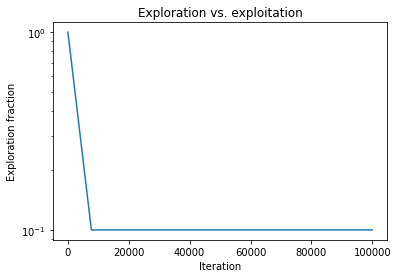

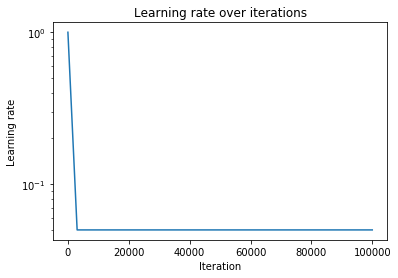

In [6]:
plt.plot(exps)
plt.title('Exploration vs. exploitation')
plt.xlabel('Iteration')
plt.ylabel('Exploration fraction')
plt.yscale('log')
plt.show()
plt.plot(alphas)
plt.title('Learning rate over iterations')
plt.xlabel('Iteration')
plt.ylabel('Learning rate')
plt.yscale('log')
plt.show()

In [183]:
print('table: [red, green, blue]')
print('buckets: [green, red]\n')

print('-'*98)
print('action: \t|\tpickL\t|\tpickM\t|\tpickR\t|\tputL\t|\tputR\t|')
print('-'*98)
for i, table in enumerate(['empty', 'red', 'green', 'blue']):
    s = 'arm: ' + table + '\t|'
    for j, v in enumerate(Q[1, 2, 3, i, 2, 1, :]):
        s += '%.5f' % v + '\t|'
    print(s)
print('-'*98)

table: [red, green, blue]
buckets: [green, red]

--------------------------------------------------------------------------------------------------
action: 	|	pickL	|	pickM	|	pickR	|	putL	|	putR	|
--------------------------------------------------------------------------------------------------
arm: empty	|540.26216	|531.68850	|658.26995	|588.03808	|578.21548	|
arm: red	|0.00000	|0.00000	|0.00000	|0.00000	|0.00000	|
arm: green	|0.00000	|0.00000	|0.00000	|0.00000	|0.00000	|
arm: blue	|0.00000	|0.00000	|0.00000	|0.00000	|0.00000	|
--------------------------------------------------------------------------------------------------


In [184]:
print('table: [red, empty, blue]')
print('buckets: [green, red]\n')

print('-'*98)
print('action: \t|\tpickL\t|\tpickM\t|\tpickR\t|\tputL\t|\tputR\t|')
print('-'*98)
for i, table in enumerate(['empty', 'red', 'green', 'blue']):
    s = 'arm: ' + table + '\t|'
    for j, v in enumerate(Q[1, 0, 3, i, 2, 1, :]):
        s += '%.5f' % v + '\t|'
    print(s)
print('-'*98)

table: [red, empty, blue]
buckets: [green, red]

--------------------------------------------------------------------------------------------------
action: 	|	pickL	|	pickM	|	pickR	|	putL	|	putR	|
--------------------------------------------------------------------------------------------------
arm: empty	|0.00000	|0.00000	|0.00000	|0.00000	|0.00000	|
arm: red	|490.39976	|490.08167	|512.22850	|589.24029	|508.63378	|
arm: green	|510.84104	|481.16476	|432.40850	|514.58223	|599.99418	|
arm: blue	|407.68603	|261.22442	|358.55292	|519.96607	|341.36808	|
--------------------------------------------------------------------------------------------------


In [9]:
def getTrajectory(Q, rationality=1.0, maxLength=200):
    '''
    Obtain a trajectory following the optimal policy based on Q.
    
    Parameters:
        Q: np.array, shape: (4, 4, 4, 4, 4, 4, 5)
            the first six dimensions represent the state variables c1, ... last_r
            the last dimension represents the action
        rationality (float): between 0 and 1. Fraction of optimal actions
            When < 1.0 the trajectory will sometimes contain random actions
        maxLength (int): the length of the trajectory
    '''
    env = Environment()
    traj_s = []
    traj_a = []
    traj_r = []
    s = env.get_current_state()
    for i in range(maxLength):
        a = actions[np.argmax(Q[s[c1], s[c2], s[c3], s[arm], s[last_l], s[last_r], :])]
        if rationality < np.random.random():
            a = actions[np.random.randint(0, 5)]
        traj_s.append(s)
        traj_a.append(a)
        traj_r.append(env.get_reward(s, a))
        s = env.execute_action(a)
    return traj_s, traj_a, traj_r

100%|██████████| 101/101 [02:17<00:00,  1.36s/it]


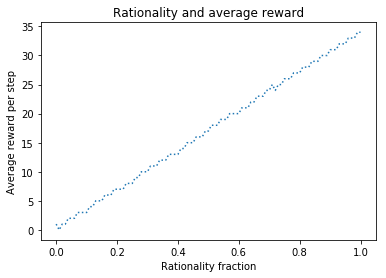

In [10]:
r_sums = []
n_trajs = 1000
lengths = 100
for i in tqdm(np.arange(0, 1.01, 0.01)):
    rsum = 0
    for j in range(n_trajs):
        _, _, rs = getTrajectory(Q, rationality=i, maxLength=lengths)
        rsum += np.sum(rs)
    r_sums.append(rsum)
    
plt.plot(np.arange(0, 1.01, 0.01), np.array(r_sums) / (n_trajs * lengths), linestyle=':')
plt.xlabel('Rationality fraction')
plt.ylabel('Average reward per step')
plt.title('Rationality and average reward')
plt.show()

In [11]:
def getTrajectories(Q, M=100, rationality=1.0, maxLength=50):
    '''
    Returns:
        np.array of shape (M, 3, maxLength)
        [:, 0, :]: states (array of state variables)
        [:, 1, :]: actions (string)
        [:, 2, :]: rewards (int)
    '''
    
    trajs = []
    for i in range(M):
        trajs.append([getTrajectory(Q, rationality, maxLength)])
    return np.array(trajs).reshape(M,3,maxLength)

In [12]:
def sa_to_features(s, a):
    '''
    XXX todo
    '''
    f = []
    for sv in range(len(s)):
        sv_one_hot = [0] * 4
        sv_one_hot[s[sv]] = 1
        f += sv_one_hot
    a_one_hot = [0] * 5
    a_one_hot[actions.index(a)] = 1
    f += a_one_hot
    return np.array(f)

feats = sa_to_features([1, 2, 3, 0, 1, 2], 'putR')
print('state as one hot encoded features:')
print(np.reshape(np.array(feats[:-5]), (4, 6)))
print('action as one hot encoded features:')
print(np.array(feats[-5:]))

state as one hot encoded features:
[[0 1 0 0 0 0]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [0 0 0 0 1 0]]
action as one hot encoded features:
[0 0 0 0 1]


In [13]:
def traj_to_features(traj):
    '''
    XXX todo
    '''
    res = []
    traj = np.array(traj)
    for i in range(traj.shape[1]):
        s = traj[0,i]
        a = traj[1,i]
        res.append(sa_to_features(s, a))
    return np.array(res)

def trajs_to_features(trajs):
    '''
    XXX todo
    '''
    res = []
    for i in range(len(trajs)):
        res.append(traj_to_features(trajs[i]))
    return np.array(res)

In [14]:
print('single state action pair as feature:')
feats = sa_to_features([1, 2, 3, 0, 1, 2], 'putR')
print(feats.shape)
print('trajectory as features:')
traj = getTrajectory(Q)
feats = traj_to_features(traj)
print(feats.shape)
print('trajectories as features:')
trajs = getTrajectories(Q)
feats = trajs_to_features(trajs)
print(feats.shape)

single state action pair as feature:
(29,)
trajectory as features:
(200, 29)
trajectories as features:
(100, 50, 29)


In [165]:
class Rpred(torch.nn.Module):
    '''
    XXX todo
    '''
    def __init__(self):
        super(Rpred, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(29, 500),
            torch.nn.ReLU()          
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(500, 200),
            torch.nn.ReLU()  
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(200, 1),
            torch.nn.Tanh()  
        )

        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        return out
    
rpred = Rpred()
optimizer = torch.optim.Adagrad(rpred.parameters())

In [189]:
losses = []
lossesv = []

iterations = 50

trajsG = getTrajectories(Q, M=1000, rationality=0.95, maxLength=200)
trajsG_features = trajs_to_features(trajsG)
trajsG_features = Variable(torch.from_numpy(trajsG_features)).float()
trajsB = getTrajectories(Q, M=1000, rationality=0.0, maxLength=200)
trajsB_features = trajs_to_features(trajsB)
trajsB_features = Variable(torch.from_numpy(trajsB_features)).float()
# XXX todo: requires gradient false for trajs_features

trajsGv = getTrajectories(Q, M=100, rationality=0.95, maxLength=200)
trajsGv_features = trajs_to_features(trajsGv)
trajsGv_features = Variable(torch.from_numpy(trajsGv_features)).float()
trajsBv = getTrajectories(Q, M=100, rationality=0.0, maxLength=200)
trajsBv_features = trajs_to_features(trajsBv)
trajsBv_features = Variable(torch.from_numpy(trajsBv_features)).float()

rpred.train()
for i in tqdm(range(iterations)):
        
    rpredsG = rpred(trajsG_features).view(trajsG_features.data.shape[0],trajsG_features.data.shape[1])
    rpredsB = rpred(trajsB_features).view(trajsB_features.data.shape[0],trajsB_features.data.shape[1])
    rpredsGv = rpred(trajsGv_features).view(trajsGv_features.data.shape[0],trajsGv_features.data.shape[1])
    rpredsBv = rpred(trajsBv_features).view(trajsBv_features.data.shape[0],trajsBv_features.data.shape[1])

#     R_of_zeta = torch.sum(rpreds, dim=1)

#     objective = (1.0 / trajs_features.data.shape[0]) * torch.sum(R_of_zeta) - torch.log(torch.sum(torch.exp(R_of_zeta)))
    
    objective = (torch.sum(rpredsG) - torch.sum(rpredsB))
    objectivev = (torch.sum(rpredsGv) - torch.sum(rpredsBv))
    
    loss = - (objective / 1000.0)
    lossv = - (objectivev / 100.0)
    losses.append(loss.data[0])  
    lossesv.append(lossv.data[0])

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
rpred.eval()

100%|██████████| 50/50 [12:54<00:00, 15.49s/it]


Rpred (
  (layer1): Sequential (
    (0): Dropout (p = 0.5)
    (1): Linear (29 -> 500)
    (2): ReLU ()
  )
  (layer2): Sequential (
    (0): Dropout (p = 0.5)
    (1): Linear (500 -> 200)
    (2): ReLU ()
  )
  (layer3): Sequential (
    (0): Dropout (p = 0.5)
    (1): Linear (200 -> 1)
    (2): Tanh ()
  )
)

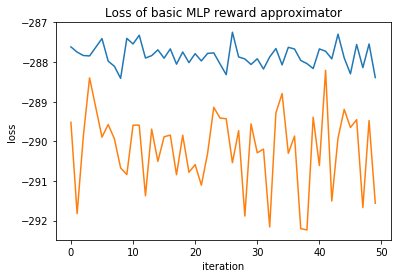

In [190]:
plt.plot(np.arange(iterations), losses)
plt.plot(np.arange(iterations), lossesv)
plt.title('Loss of basic MLP reward approximator')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

In [ ]:
def qLearning_from_estimates(iterations=10000, traj_len=100, alpha=1.0, alpha_decay=0.999,  \
              alpha_min=0.05, gamma=0.95, exp=1.0,  exp_decay=0.990, exp_min=0.5, \
              stats=False):
    env = Environment()
    gamma = 0.95
    Q = np.zeros((4, 4, 4, 4, 4, 4, 5))
    exp = 1.0
    if stats:
        alphas = []
        exps = []
    for it in tqdm(range(iterations)):
        if stats:
            alphas.append(alpha)
            exps.append(exp)
        env.reset()
        s = env.get_current_state()
        for step in range(traj_len):
            if np.random.uniform(0, 1) <= exp:
                a = actions[np.random.randint(0, 5)]
            else:
                a = actions[np.argmax(Q[s[c1], s[c2], s[c3], s[arm], s[last_l], s[last_r], :])]
            features = sa_to_features(s, a)
            features = Variable(torch.from_numpy(features)).float()
            pred = rpred(features)
            r = pred.data[0]
            sn = env.execute_action(a)
            updateQ(Q, s, a, r, sn, gamma, alpha)
            s = sn
        alpha = max(alpha * alpha_decay, alpha_min)
        exp = max(exp * exp_decay, exp_min)
    if stats:
        return Q, alphas, exps
    return Q

Q_estim = qLearning_from_estimates(iterations=100000, exp_decay=0.9997, exp_min=0.1)

In [185]:
np.save('Qs_estim.npy', Q_estim)

In [186]:
print('table: [red, empty, blue]')
print('buckets: [green, red]\n')

print('-'*98)
print('action: \t|\tpickL\t|\tpickM\t|\tpickR\t|\tputL\t|\tputR\t|')
print('-'*98)
for i, table in enumerate(['empty', 'red', 'green', 'blue']):
    s = 'arm: ' + table + '\t|'
    Q_show = Q[1, 0, 3, i, 2, 1, :] - np.min(Q[1, 0, 3, i, 2, 1, :])
    if (np.max(Q[1, 0, 3, i, 2, 1, :]) - np.min(Q[1, 0, 3, i, 2, 1, :])) != 0:
        Q_show /= (np.max(Q[1, 0, 3, i, 2, 1, :]) - np.min(Q[1, 0, 3, i, 2, 1, :]))
    for j, v in enumerate(Q_show):
        s += '%.5f' % v + '\t|'
    print(s)
print('-'*98)

print('table: [red, empty, blue]')
print('buckets: [green, red]\n')

print('-'*98)
print('action: \t|\tpickL\t|\tpickM\t|\tpickR\t|\tputL\t|\tputR\t|')
print('-'*98)
for i, table in enumerate(['empty', 'red', 'green', 'blue']):
    s = 'arm: ' + table + '\t|'
    Q_show = Q_estim[1, 0, 3, i, 2, 1, :] - np.min(Q_estim[1, 0, 3, i, 2, 1, :])
    if (np.max(Q_estim[1, 0, 3, i, 2, 1, :]) - np.min(Q_estim[1, 0, 3, i, 2, 1, :])) != 0:
        Q_show /= (np.max(Q_estim[1, 0, 3, i, 2, 1, :]) - np.min(Q_estim[1, 0, 3, i, 2, 1, :]))      
    for j, v in enumerate(Q_show):
        s += '%.5f' % v + '\t|'
    print(s)
print('-'*98)

table: [red, empty, blue]
buckets: [green, red]

--------------------------------------------------------------------------------------------------
action: 	|	pickL	|	pickM	|	pickR	|	putL	|	putR	|
--------------------------------------------------------------------------------------------------
arm: empty	|0.00000	|0.00000	|0.00000	|0.00000	|0.00000	|
arm: red	|0.00321	|0.00000	|0.22335	|1.00000	|0.18710	|
arm: green	|0.46801	|0.29093	|0.00000	|0.49034	|1.00000	|
arm: blue	|0.56605	|0.00000	|0.37616	|1.00000	|0.30974	|
--------------------------------------------------------------------------------------------------
table: [red, empty, blue]
buckets: [green, red]

--------------------------------------------------------------------------------------------------
action: 	|	pickL	|	pickM	|	pickR	|	putL	|	putR	|
--------------------------------------------------------------------------------------------------
arm: empty	|0.00000	|0.00000	|0.00000	|0.00000	|0.00000	|
arm: red	|0.65371	|0.0